In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14


In [78]:
import numpy as np
import pandas as pd
import glob
import os
import sys

In [3]:
def histoplot(df, dfvar, num_bins = 10, figsize=(6, 4), title=""):
    
    fig, ax0 = plt.subplots(1, 1, figsize=figsize)
    _, _, _ = ax0.hist(df[dfvar], num_bins, label=dfvar)
    ax0.set_xlabel(dfvar)
    ax0.set_ylabel('Events/bin')
    ax0.set_title(title)
    ax0.legend()
    fig.tight_layout()
    plt.show()

In [4]:
def plot_energy(df, num_bins = 20, xmin=2e+4, xmax=4e+4, figsize=(6, 4), title=""):
    energies = df.groupby("event").sum().amplitude.values
    
    fig, ax0 = plt.subplots(1, 1, figsize=figsize)
    _, _, _ = ax0.hist(energies, num_bins, (xmin, xmax))
    ax0.set_xlabel("Event energy")
    ax0.set_ylabel('Events/bin')
    ax0.set_title(title)
    

    fig.tight_layout()
    plt.show()

In [5]:
def plot_time(df, num_bins = 20, xmin=0.0, xmax=5e+3, timebin=200, figsize=(6, 4), title=""):
    
    fig, ax0 = plt.subplots(1, 1, figsize=figsize)
    _, _, _ = ax0.hist(df.time * timebin, num_bins, (xmin, xmax), weights=df.charge)
    ax0.set_xlabel("Event Time")
    ax0.set_ylabel('Events/bin')
    ax0.set_title(title)
    
    fig.tight_layout()
    plt.show()

In [6]:
def select_image_from_df(df, evtsel = 10):
    gevt = df.groupby('event')
    n = 8
    charge_matrix = np.zeros((n, n))
    for event_number, group in gevt:
        if event_number == evtsel:
            for _, row in group.iterrows():
                sensor_id = row['sensor_id']
                charge = row['amplitude']
                charge_matrix[sensor_id // n, sensor_id % n] = charge
            break
    return charge_matrix

In [7]:
def plot_image(charge_matrix, figsize=(6, 6)):
    plt.figure(figsize=figsize)
    plt.imshow(charge_matrix, cmap='viridis', interpolation='none')
    plt.colorbar(label='Charge')
    plt.title(f'Charge Matrix for Event {evtsel}')
    plt.xlabel('Sensor X')
    plt.ylabel('Sensor Y')
    plt.show()

In [8]:
def collect_images(df, n= 8):
    events = np.unique(df['event'])
    images = np.zeros((events.shape[0],n,n))
    gevt = df.groupby('event')
    i=0
    charge_matrix = np.zeros((n, n))
    for event_number, group in gevt:
        for _, row in group.iterrows():
            sensor_id = row['sensor_id']
            charge = row['amplitude']
            charge_matrix[sensor_id // n, sensor_id % n] = charge
        images[i]= charge_matrix
        i+=1
    return images

In [40]:
def image_from_csv(csvname):
    """
    Asummes a name of the form isensor_data_nn.csv and picks number nn
    """
    f1 = filenm.split("_")
    fn = f1[-1].split(".")[0]
    return f"images_{fn}.npy"

In [140]:
def prepare_images_and_metadata(csvdir, imgsufx="Img"):
    """
    Input: csvdir of the form: '/home/path/csvdir/, containing files with names:
    isensor_data_nn.csv and gamma_interactions_nn.csv

    Actions:
    1. create a directory of images: '/home/path/imgdir/ where imgdir = csvidr+suffix
    2. glob the directory, getting a list of files:
    /home/path/imgdir/isensor_data_nn.csv and /home/path/imgdir/gamma_interactions_nn.csv

    3. each file gamma_interactions_nn.csv must be copied in imgfile directory as metadata_nn.csv
    4. each file /home/path/imgdir/isensor_data_nn.csv is processed to produce an image that is written 
    in image directory as images_nn.npy
    
    """
    def create_directory(directory_name):
        """
        Create directory if if doesn't exist
        
        """
        
        if not os.path.exists(directory_name):
            os.makedirs(directory_name)
            print(f"Directory '{directory_name}' created.")
        else:
            print(f"Directory '{directory_name}' already exists.")
            
        
    def imgdir_from_csvdir():
        """
        1. Split the full path using / as delimiter (sn)
        2. Get the root (e.g, the path minus the actual directory) (pn)
        3. Get the name of the csvdir (fa)
        4. Build the image dir by appending imgsufx to fa and return full path
        
        """
        sn = csvdir.split("/")
        fpl = sn[0:-1]
        pn  = '/'.join(fpl)
        fn  = sn[-1]
        fa  = f"{pn}" 
        return f"{pn}/{fn}{imgsufx}"
        
        
    def get_file_prefix_and_number(path):
        """
        1. Split the full path (/) and get last element: this is the file name (fn)
        2. Split again (_): the list (fns) contains all atoms of the name
        3. Split again the last atom (.csv) using "." and get the first element (the number nn)
        4. return the prefix and the number 
        
        """
        
        fn = path.split("/")[-1]
        fns = fn.split("_")
        nn = fns[-1].split(".")[0]
        return fns[0], nn
        

    def create_image_file(dfg, imgf):
        """
        1. get the image
        2. save as npy in images dir
        """
        
        images = collect_images(dfg)
        np.save(imgf, images)

    def create_metadata_file(dfg, metaf):
        """
        1. rename columns
        2. save as metadata in images dir.
        """
        
        dfg.rename(columns={'event': 'event_id',
                    'x': 'initial_x',
                    ' y': 'initial_y',
                    ' z': 'initial_z'}, 
                    inplace=True)
        dfg.to_csv(metaf, index=False)


    imgdir = imgdir_from_csvdir()
    create_directory(imgdir)
    csvfiles = glob.glob(f"{csvdir}/*.csv")

    for n, csvf in enumerate(csvfiles):
        print(f"Reading file {n+1}")
        df = pd.read_csv(csvf, header=0).sort_values(by='event').reset_index(drop=True)
        pfx, nn = get_file_prefix_and_number(csvf)

        if pfx == "gamma":
            metaf = f"{imgdir}/metadata_{nn}.csv"
            print(f" creating metadata file = {metaf}")
            create_metadata_file(df, metaf)
        elif pfx == "isensor":
            imgf = f"{imgdir}/images_{nn}.npy"
            print(f" creating image = {imgf}")
            create_image_file(df, imgf)
        else:
            print("not implemented")
            break

    
    
   

In [92]:
csvdir = "/Users/jjgomezcadenas/Data/G4Prods/crystalMT/csiGammasUniform"
csvname = "isensor_data_4.csv"
gname = "gamma_interactions_4.csv"

In [42]:
imgn = image_from_csv(csvname)

In [43]:
imgn

'images_4.npy'

In [68]:
df = pd.read_csv(f"{csvdir}/{csvname}", header=0).sort_values(by='event').reset_index(drop=True)
df

,event,sensor_id,amplitude
0,30000,20,370
1,30000,5,316
2,30000,14,333
3,30000,48,333
4,30000,58,318
...,...,...,...
639995,39999,8,428
639996,39999,9,515
639997,39999,38,569
639998,39999,46,544


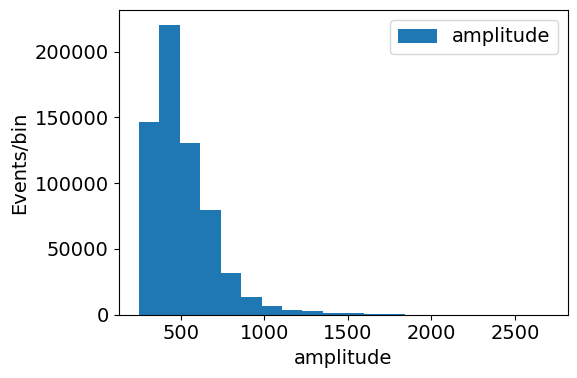

In [18]:
histoplot(df, "amplitude", num_bins = 20, figsize=(6, 4), title="")

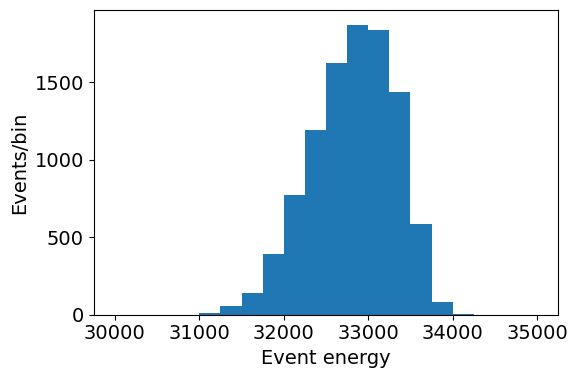

In [19]:
plot_energy(df, num_bins = 20, xmin=3e+4, xmax=3.5e+4,figsize=(6, 4), title="")

In [93]:
dfg = pd.read_csv(f"{csvdir}/{gname}", header=0).sort_values(by='event').reset_index(drop=True)
dfg

,event,x,y,z
0,30000,16.75060,11.437500,7.99588
1,30001,16.24240,9.781660,5.41388
2,30002,-9.50133,0.604470,-6.28260
3,30003,19.73120,8.004260,-4.40820
4,30004,18.56390,-19.522400,6.16568
...,...,...,...,...
9995,39995,10.21980,-8.854860,-4.88416
9996,39996,19.82380,-2.767440,-4.06860
9997,39997,22.67850,-0.584109,-5.06053
9998,39998,12.28930,-4.631500,5.15382


In [105]:
dfg.rename(columns={'event': 'event_id',
                    'x': 'initial_x',
                    ' y': 'initial_y',
                    ' z': 'initial_z'}, 
                    inplace=True)

In [106]:
dfg

,event_id,initial_x,initial_y,initial_z
0,30000,16.75060,11.437500,7.99588
1,30001,16.24240,9.781660,5.41388
2,30002,-9.50133,0.604470,-6.28260
3,30003,19.73120,8.004260,-4.40820
4,30004,18.56390,-19.522400,6.16568
...,...,...,...,...
9995,39995,10.21980,-8.854860,-4.88416
9996,39996,19.82380,-2.767440,-4.06860
9997,39997,22.67850,-0.584109,-5.06053
9998,39998,12.28930,-4.631500,5.15382


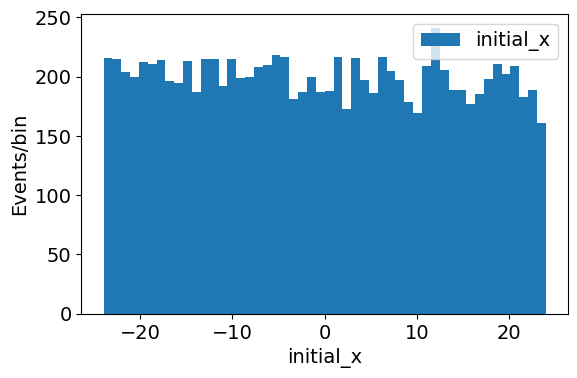

In [107]:
histoplot(dfg, "initial_x", num_bins = 50, figsize=(6, 4), title="")

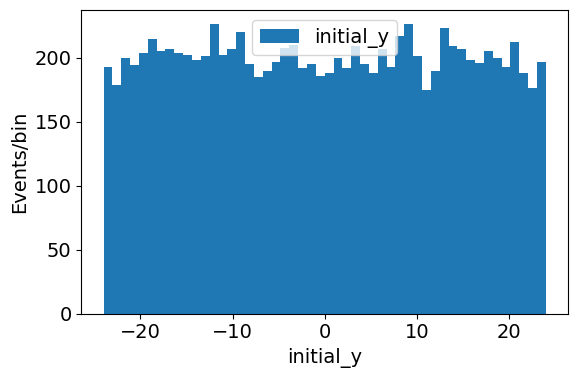

In [108]:
histoplot(dfg, "initial_y", num_bins = 50, figsize=(6, 4), title="")

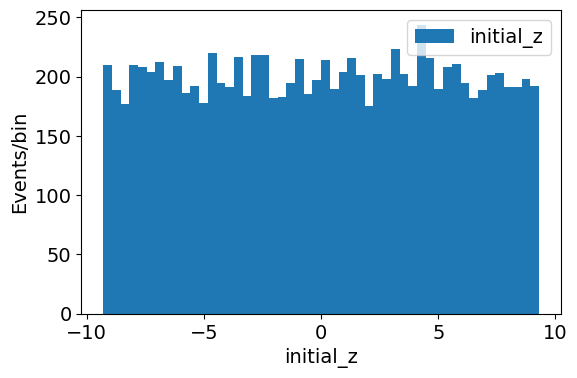

In [109]:
histoplot(dfg, "initial_z", num_bins = 50, figsize=(6, 4), title="")

### Plot a few events

In [22]:
evtsel = df.event[0]
charge_matrix = select_image_from_df(df,evtsel)


In [23]:
charge_matrix

array([[ 313.,  325.,  378.,  337.,  321.,  316.,  326.,  272.],
       [ 327.,  347.,  373.,  360.,  349.,  363.,  333.,  328.],
       [ 366.,  380.,  394.,  388.,  370.,  342.,  367.,  322.],
       [ 323.,  371.,  380.,  402.,  394.,  389.,  401.,  356.],
       [ 346.,  362.,  376.,  370.,  515.,  606.,  614.,  445.],
       [ 361.,  347.,  380.,  495.,  801., 1022.,  990.,  782.],
       [ 333.,  322.,  332.,  604., 1044., 1510., 1425., 1055.],
       [ 319.,  300.,  318.,  551.,  921., 1424., 1330.,  999.]])

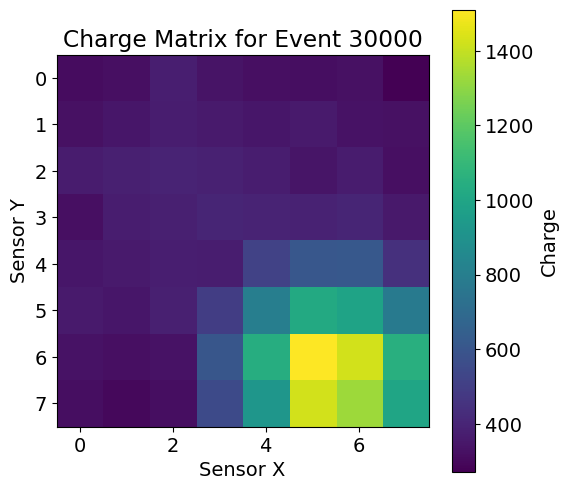

In [24]:
plot_image(charge_matrix)

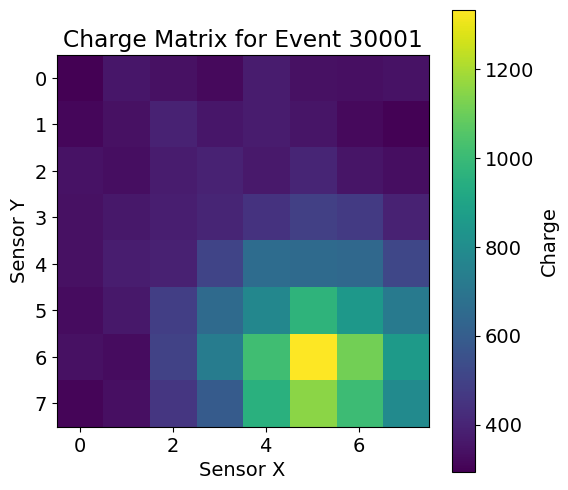

In [28]:
evtsel = df.event[100]
charge_matrix = select_image_from_df(df, evtsel)
plot_image(charge_matrix)

### Script to convert csv to npy

In [141]:
prepare_images_and_metadata(csvdir)

Directory '/Users/jjgomezcadenas/Data/G4Prods/crystalMT/csiGammasUniformImg' already exists.
Reading file 1
 creating metadata file = /Users/jjgomezcadenas/Data/G4Prods/crystalMT/csiGammasUniformImg/metadata_93.csv
Reading file 2
 creating metadata file = /Users/jjgomezcadenas/Data/G4Prods/crystalMT/csiGammasUniformImg/metadata_87.csv
Reading file 3
 creating image = /Users/jjgomezcadenas/Data/G4Prods/crystalMT/csiGammasUniformImg/images_65.npy
Reading file 4
 creating metadata file = /Users/jjgomezcadenas/Data/G4Prods/crystalMT/csiGammasUniformImg/metadata_78.csv
Reading file 5
 creating image = /Users/jjgomezcadenas/Data/G4Prods/crystalMT/csiGammasUniformImg/images_71.npy
Reading file 6
 creating image = /Users/jjgomezcadenas/Data/G4Prods/crystalMT/csiGammasUniformImg/images_59.npy
Reading file 7
 creating metadata file = /Users/jjgomezcadenas/Data/G4Prods/crystalMT/csiGammasUniformImg/metadata_50.csv
Reading file 8
 creating metadata file = /Users/jjgomezcadenas/Data/G4Prods/crystal

In [124]:
img =np.load("/Users/jjgomezcadenas/Data/G4Prods/crystalMT/csiGammasUniformImg/images_58.npy")

In [129]:
img[0]

array([[ 584.,  715.,  702.,  579.,  421.,  357.,  338.,  305.],
       [ 735.,  981., 1000.,  814.,  527.,  356.,  355.,  320.],
       [ 845., 1155., 1246.,  884.,  597.,  432.,  374.,  315.],
       [ 822., 1059., 1070.,  826.,  549.,  427.,  360.,  334.],
       [ 565.,  754.,  760.,  621.,  481.,  354.,  376.,  370.],
       [ 390.,  451.,  472.,  439.,  378.,  357.,  334.,  352.],
       [ 351.,  345.,  365.,  365.,  376.,  355.,  321.,  321.],
       [ 342.,  344.,  337.,  356.,  372.,  334.,  317.,  316.]])

In [130]:
img =np.load("/Users/jjgomezcadenas/Data/G4Prods/crystalMT/csiGammasUniformImg/images_71.npy")

In [131]:
img[0]

array([[ 318.,  355.,  363.,  366.,  316.,  350.,  312.,  307.],
       [ 337.,  408.,  375.,  397.,  349.,  388.,  326.,  291.],
       [ 335.,  365.,  359.,  374.,  364.,  352.,  364.,  318.],
       [ 345.,  368.,  358.,  370.,  400.,  369.,  370.,  356.],
       [ 376.,  378.,  393.,  435.,  423.,  361.,  368.,  385.],
       [ 348.,  365.,  606.,  838.,  779.,  563.,  378.,  367.],
       [ 347.,  466.,  962., 1609., 1516.,  904.,  460.,  342.],
       [ 328.,  439.,  998., 1770., 1745.,  990.,  449.,  363.]])

In [134]:
dfg = pd.read_csv("/Users/jjgomezcadenas/Data/G4Prods/crystalMT/csiGammasUniformImg/metadata_93.csv", header=0)
dfg

,event_id,initial_x,initial_y,initial_z
0,920000,-8.196250,-1.25166,0.004355
1,920001,-0.598537,14.98440,3.245790
2,920002,13.075600,22.81940,-7.517930
3,920003,16.496000,-2.79531,8.637900
4,920004,-6.240000,21.60230,-8.921290
...,...,...,...,...
9995,929995,-23.650100,14.30780,-3.712020
9996,929996,-14.210000,19.88630,6.441090
9997,929997,16.049800,1.56745,2.024390
9998,929998,-0.636148,13.26930,6.634890


In [135]:
dfg = pd.read_csv("/Users/jjgomezcadenas/Data/G4Prods/crystalMT/csiGammasUniformImg/metadata_50.csv", header=0)
dfg

,event_id,initial_x,initial_y,initial_z
0,490000,-20.139200,-15.00900,5.871040
1,490001,15.521600,-6.89675,-8.465570
2,490002,-17.055500,-21.58530,0.934427
3,490003,13.091800,-12.17920,4.709460
4,490004,-10.891800,14.20230,-7.106980
...,...,...,...,...
9995,499995,-1.355210,6.51078,1.789220
9996,499996,7.113240,-10.64890,-1.145030
9997,499997,17.733600,-18.47830,-2.499650
9998,499998,18.045000,22.18350,1.267010
